In [ ]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.nn.init import (
    kaiming_normal_,
    constant_
)
import gym
class QNet(torch.nn.Module):
    def __init__(self, state_dim=4, action_dim=2):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, action_dim) 
        )
    def forward(self, state):
        q = self.fc(state)
        value, action = q.max(dim=-1) 
        return value, action
    def select_action(self, state, epsilon=0.0):
        if torch.rand(1).item() < epsilon:
            return torch.tensor(gym.spaces.Discrete(2).sample(), device=state.device)
        else:
            with torch.no_grad():
                q = self.fc(state)
                _, action = q.max(dim=-1)
                return action

def _init_net(layer):
    """
    初始化
    """
    if isinstance(layer,(torch.nn.Linear,)):
        kaiming_normal_(layer.weight)
        constant_(layer.bias,0)
    
def get_device():
    """
    检验gpu是否可用
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

device =  get_device()
net = QNet()
net.apply(_init_net)
net.to(device=device)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


QNet(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [2]:
config = {
    "optim":"Adam",
    "lr":0.005,
    "n_epoch":1000,
    "weight_decay":1e-5,
    "gamma":0.9,
    "limit_step":100,
    "grad_clip_norm": 1.0,
    "val_epoch":5,
    "eps_start": 0.9,   
    "eps_end": 0.05,    
    "eps_decay": 100
}
# 定义部分超参数

In [3]:
def dev(net,device,visual=False):
    net.eval()
    render_mode = "human" if visual else None
    env = gym.make('CartPole-v1',render_mode=render_mode)
    try:
        state,_ = env.reset()
        state = torch.tensor(state,dtype=torch.float32,device=device)
        done = False
        total_reward = 0
        with torch.no_grad():
            while not done:
                # 跑一轮游戏
                _,action = net(state)
                    
                next_state, reward, terminated, truncated, _ = env.step(int(action))
                next_state = torch.tensor(next_state,
                                        dtype=torch.float32,
                                        device=device)
                total_reward += reward
                done = terminated or truncated
                state = next_state
        print(f"奖励总和为{total_reward}")
        return total_reward
    finally:
        env.close()

In [ ]:
def train(config,net,device):
    net.train()
    env = gym.make('CartPole-v1',render_mode=None)
    optim = getattr(torch.optim,config["optim"])(net.parameters(),
                                                 lr=config["lr"],
                                                 weight_decay=config["weight_decay"])
    lossfunction = torch.nn.MSELoss()
    gamma = config["gamma"]
    total_rewards = []
    max_total_rewards = 0
    step = 0
    limit_grad = config["grad_clip_norm"]
    val_epoch = config["val_epoch"]
    all_current_values = []
    all_td_targets = []
    # 初始化训练前置参数
    for epoch in range(config["n_epoch"]):
        state,_ = env.reset()
        state = torch.tensor(state,dtype=torch.float32,device=device)
        done = False
        total_reward = 0
        game_step = 0
        epsilon = max(config["eps_end"], config["eps_start"] - epoch / config["eps_decay"])
        # 积累经验
        all_current_values.clear()
        all_td_targets.clear()
        while not done:
            # 跑一轮游戏
            action = net.select_action(state, epsilon)
            current_value = net.fc(state)[action]
            all_current_values.append(current_value)  # 保存带梯度的张量
            game_step+=1
            next_state, reward, terminated, truncated, _ = env.step(int(action))
            
            total_reward += reward

            done = terminated or truncated

            next_state = torch.tensor(next_state,
                                      dtype=torch.float32,
                                      device=device)
            
            with torch.no_grad():
                # 禁止计算图
                next_value,_ = net(next_state)
                TD_target = gamma*next_value*(1-done) + torch.tensor(reward,
                                                                 dtype=torch.float32,
                                                                 device=device)
                # 如果done也就是在最优情况下 下一个t结束 由于已经结束所以不考虑
            all_td_targets.append(TD_target)  # 保存无梯度的目标值
            state = next_state
        if game_step:
            current_values = torch.stack(all_current_values)
            td_targets = torch.stack(all_td_targets)
            total_loss = lossfunction(current_values, td_targets)
            avg_loss = total_loss / len(all_current_values)
            optim.zero_grad()
            avg_loss.backward()
            clip_grad_norm_(net.parameters(), limit_grad)
            optim.step()
        print(f"epoch_{epoch}'s total_reward = {total_reward},run{game_step}")
        total_rewards.append(total_reward)
        if epoch % val_epoch==0:
            dev_total_reward = dev(net=net,device=device)  
            if dev_total_reward > max_total_rewards:
                max_total_rewards = dev_total_reward
                step = 0
                torch.save(net.state_dict(),"./model/CartPole-v1.pth")
            else:
                step+=1
        if step > config["limit_step"]:
            print(f"dev_max_reward{max_total_rewards}")
            break
        # 设置早停机制
    env.close()
    return total_rewards
    # 返回部分统计结果用于绘制图


In [5]:
def showing(total_rewards):
    """
    绘制变化图
    """
    import matplotlib.pyplot as plt
    plt.figure()  # 创建基础画布
    plt.plot(total_rewards)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Epoch')
    plt.show()

In [6]:
total_rewards = train(config=config,net=net,device=device)

epoch_0's total_reward = 23.0,run23
奖励总和为46.0
epoch_1's total_reward = 15.0,run15
epoch_2's total_reward = 52.0,run52
epoch_3's total_reward = 27.0,run27
epoch_4's total_reward = 14.0,run14
epoch_5's total_reward = 19.0,run19
奖励总和为18.0
epoch_6's total_reward = 22.0,run22
epoch_7's total_reward = 34.0,run34
epoch_8's total_reward = 10.0,run10
epoch_9's total_reward = 18.0,run18
epoch_10's total_reward = 11.0,run11
奖励总和为10.0
epoch_11's total_reward = 11.0,run11
epoch_12's total_reward = 22.0,run22
epoch_13's total_reward = 10.0,run10
epoch_14's total_reward = 17.0,run17
epoch_15's total_reward = 12.0,run12
奖励总和为10.0
epoch_16's total_reward = 14.0,run14
epoch_17's total_reward = 16.0,run16
epoch_18's total_reward = 13.0,run13
epoch_19's total_reward = 21.0,run21
epoch_20's total_reward = 19.0,run19
奖励总和为10.0
epoch_21's total_reward = 15.0,run15
epoch_22's total_reward = 10.0,run10
epoch_23's total_reward = 12.0,run12
epoch_24's total_reward = 13.0,run13
epoch_25's total_reward = 11.0,run1

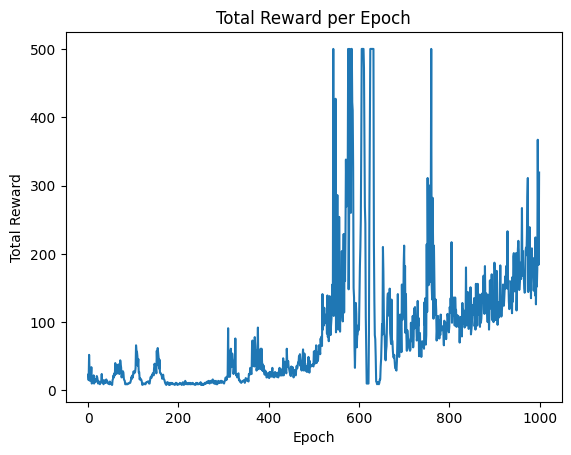

In [7]:
showing(total_rewards)

In [16]:
params = torch.load("./model/CartPole-v1.pth")
net = QNet()
net.load_state_dict(params)
net.to(device)
dev(net,device,visual=True)

奖励总和为500.0


500.0